# Control Allocation / Mixing

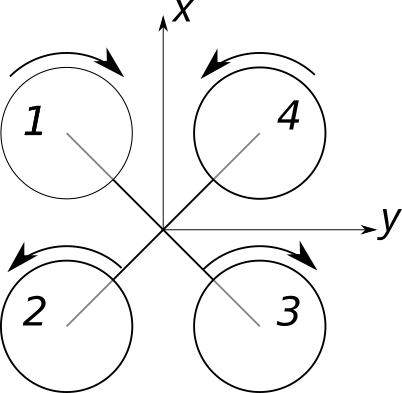

The quad can create a force in z direction and moments in x, y and z direction ($T$, $M_x$, $M_y$ and $M_z$ by 
commanding the motors with $U_i$.

$
\begin{pmatrix}
M_x\\ M_y \\ M_z\\ T
\end{pmatrix}
=
\underbrace{\begin{pmatrix}
\kappa_T \cdot l_1 \sin \phi_1 & \kappa_T \cdot l_2 \sin \phi_2 & \kappa_T \cdot l_3 \sin \phi_3 & \kappa_T \cdot l_4 \sin \phi_4 \\
\kappa_T \cdot l_1 \cos \phi_1 & \kappa_T \cdot l_2 \cos \phi_2 & \kappa_T \cdot l_3 \cos \phi_3 & \kappa_T \cdot l_4 \cos \phi_4 \\
-\kappa_M & \kappa_M & -\kappa_M & \kappa_M \\
\kappa_T & \kappa_T & \kappa_T & \kappa_T \\
\end{pmatrix}}_{\boldsymbol{B}}
\cdot
\begin{pmatrix}
U_1\\ U_2 \\ U_3 \\ U_4
\end{pmatrix}
$

With a unitless variant $\tilde{\boldsymbol{B}}$ of $\boldsymbol{B}$, we get

$
\begin{pmatrix}
\tilde{M}_x\\ \tilde{M}_y \\ \tilde{M}_z\\ \tilde{T}
\end{pmatrix}
=
\underbrace{\begin{pmatrix}
1 & 1 & -1 & -1 \\
1 & -1 & -1 & 1 \\
-1 & 1 & -1 & 1 \\
1 & 1 & 1 & 1 
\end{pmatrix}}_{\tilde{\boldsymbol{B}}}
\cdot
\begin{pmatrix}
U_1\\ U_2 \\ U_3 \\ U_4
\end{pmatrix}
$

In [1]:
import numpy as np

In [2]:
B = np.array([
    [ 1,  1, -1, -1],
    [ 1, -1, -1,  1],
    [-1,  1, -1,  1],
    [ 1,  1,  1,  1]
])

In [3]:
B_ = np.linalg.inv(B)
B_

array([[ 0.25,  0.25, -0.25,  0.25],
       [ 0.25, -0.25,  0.25,  0.25],
       [-0.25, -0.25, -0.25,  0.25],
       [-0.25,  0.25,  0.25,  0.25]])

The inverse can be used to calculate the motor commands. But the resuling commands might exceed the commandable limits 
$[U_\mathrm{min}, U_\mathrm{max}]$. There are several strategies to solve that issue. Quick investigations revealed the following options:

1. **Naive Clipping**
 
    Everything exceeding the limits is cutted back to the limit. Neither commanded moments, nor commanded throttle might be fullfilled.

4. **Faessler's prioritized desaturation**

    Priority is given to thrust vector direction, namely Roll and Pitch. In case of saturation first approach is reducing the yaw moment. Is this not enough to desaturate each command, collective thrust is adapted. Only when that does not help either the naive clipping from above is used. To achieve this the initial equation system is solved with changing unknown, partly updating the matrix $\boldsymbol{B}$.

3. **PX4 Airmode**

    The mixing is in px4 allows to increase overall lift, to reach moment demands. By operating on the outputs only, the implementation is simple compared to Faessler. It also uses simple clipping as last line of defense.
    
4. **PX4 w/o Airmode**

    Similiar to px4 airmode, but does only allow to decrease overall thrust, never increases it.

Variant (1) and (3) are implemented in the following.

In [4]:
class SimpleMixer:
    def __init__(self, B):
        self._B = B
    
    def _inverse(self):
        # calculate inverse
        return np.linalg.inv(self._B)
        
    def _scaled_inverse(self):
        B_inv = self._inverse()
        
        # scale inverse, to generate 100% (1.0) for single 1.0 input
        max_outputs = np.max(B_inv, axis=0)
        
        for i, max_out in enumerate(max_outputs):
            # value too small, ignore!
            if abs(max_out) < 1e-10:
                continue
            
            B_inv[:,i] = B_inv[:,i] / max_out
            
        return B_inv
    
    def _mix(self, T):
        # calculate inverse
        B_inv = self._scaled_inverse()
        
        # commands by inverse
        U = B_inv @ T
        
        return U
    
    def mix(self, T):
        """Crate motor outputs from moment and throttle vector T"""
        
        U_tmp = self._mix(T)
        
        # clip outputs
        U_clip = np.clip(U_tmp, 0, 1.0)

        return U_clip

In [22]:
class PX4AirmodeMixer(SimpleMixer):
    def mix(self, T):
        """Crate motor outputs from moment and throttle vector T"""
        
        U_tmp = self._mix(T)
        
        B_inv = self._scaled_inverse()
        thrust_scales = B_inv[:,-1]
        yaw_scales = B_inv[:,-2]
        
        # reduce saturation using overall thrust
        U_tmp = self._desaturate(thrust_scales, U_tmp)  
        
        # reduce saturation using yaw, thereby priotizing roll&pitch
        U_tmp = self._desaturate(yaw_scales, U_tmp)
        
        # clip outputs
        U_clip = np.clip(U_tmp, 0, 1.0)
        
        return U_clip

    def _desaturate(self, des_vec, outputs, min_output=0., max_output=1.):
        k1 = self._compute_desaturation_gain(des_vec, outputs, min_output, max_output)
        
        outputs += k1 * des_vec
        
        # equilize saturations on upper and lower limit
        k2 = 0.5 * self._compute_desaturation_gain(des_vec, outputs, min_output, max_output)
        
        outputs += k2 * des_vec
        
        return outputs
    
    def _compute_desaturation_gain(self, des_vec, outputs, min_output=0., max_output=1.):

        min_mask = outputs < min_output
        min_gains = (min_output - outputs[min_mask]) / des_vec[min_mask]
        
        max_mask = outputs > max_output
        max_gains = (max_output - outputs[max_mask]) / des_vec[max_mask]
        
        gains = [*min_gains, *max_gains]
        return min([0, *gains]) + max([0, *gains])
    
    def get_desired_input(self, U):
        """Get desired input for ratecontrol anti-windup backcalculation"""
        return np.linalg.inv(self._scaled_inverse()) @ U

# Interactive Comparison

Comparison of Simple (Clipping) mixer and px4 airmode mixer with desaturation.

In [34]:
simple_mixer = SimpleMixer(B)
px4_mixer = PX4AirmodeMixer(B)

def calc_mixes(roll, pitch, yaw, throttle):
    
    input_array = np.array([roll, pitch, yaw, throttle])
    
    outputs = px4_mixer.mix(input_array)
    outputs2 = simple_mixer.mix(input_array)
    
    desired_input = px4_mixer.get_desired_input(outputs)
    
    barwidth = 0.25
    
    r1 = np.arange(len(outputs))
    r2 = [x + barwidth for x in r1]
    
    plt.figure(2)
    plt.bar(r1, outputs, width=barwidth, label='px4_airmode')
    plt.bar(r2, outputs2, width=barwidth, label='naive clipping')
    
    plt.xlabel('motors', fontweight='bold')
    plt.xticks([r + barwidth for r in range(len(outputs))], [f'M{i}' for i in range(1,5)])
    
    plt.ylim(0.0, 1.0)
    
    plt.legend()
    
    plt.show()
    
    print(f"actual input:\t{input_array},\nno saturation input:\t{desired_input}")

In [35]:
%matplotlib inline
from matplotlib import pyplot as plt
from ipywidgets import Layout, Button, Box, IntSlider, FloatSlider, Output, Label, interactive_output

input_slider_options = {'value': 0.0, 'min':-1.0, 'max':1.0, 'step':0.01}
input_labels = ['roll','pitch', 'yaw', 'throttle',]
inputs = {label: FloatSlider(description=label, **input_slider_options) for label in input_labels}
items = [Label(value='Commands'), *inputs.values()]

vbox_layout = Layout(display='flex',
                    flex_flow='column',
                    align_items='stretch',
                    width='400px')

vbox = Box(children=items, layout=vbox_layout)

hbox_layout = Layout(display='flex',
                     flex_flow='row',
                     align_items='stretch',
                     width='100%')

out1 = interactive_output(calc_mixes, inputs)


hbox = Box(children=(vbox, out1), layout=hbox_layout)

hbox

Box(children=(Box(children=(Label(value='Commands'), FloatSlider(value=0.0, description='roll', max=1.0, min=-…

# Matrices for C code

In [92]:
template = """\
static constexpr float {name}[4][4] = {{
\t{content}
}};
"""

def format_matrix_numbers(matrix):
    return ",\n\t".join(["{{{: 01.3f}f, {: 01.3f}f, {: 01.3f}f, {: 01.3f}f}}".format(*row) for row in matrix])

In [94]:
mixer = SimpleMixer(B)
B_inverse = mixer._scaled_inverse()
B_scaled = np.linalg.inv(B_inverse)

print(
    template.format(name="motor_matrix_transposed", content=format_matrix_numbers(B_scaled.T))+"\n"+
    template.format(name="motor_matrix_inverse_transposed", content=format_matrix_numbers(B_inverse.T))
)

static constexpr float motor_matrix_transposed[4][4] = {
	{ 0.250f,  0.250f, -0.250f,  0.250f},
	{ 0.250f, -0.250f,  0.250f,  0.250f},
	{-0.250f, -0.250f, -0.250f,  0.250f},
	{-0.250f,  0.250f,  0.250f,  0.250f}
};

static constexpr float motor_matrix_inverse_transposed[4][4] = {
	{ 1.000f,  1.000f, -1.000f, -1.000f},
	{ 1.000f, -1.000f, -1.000f,  1.000f},
	{-1.000f,  1.000f, -1.000f,  1.000f},
	{ 1.000f,  1.000f,  1.000f,  1.000f}
};



# Test data

In [8]:
from itertools import combinations_with_replacement

def format_float(val):
    return "{:1.12f}f".format(val)

## Simple Mixer

example values / test cases for C++ implementation

In [9]:
mixer = SimpleMixer(B)

In [10]:
examples = []

# all combinations of boundary values
for T in combinations_with_replacement([-1.0,1],4):
    U = mixer.mix(np.array(T))
    examples.append((*T, *U))
    
# 20 random inputs
for i in range(20):
    T = 2 * np.random.random(4) - 1.0
    U = mixer.mix(T)
    
    examples.append((*T, *U))

In [11]:
for example in examples:
    print("\t\t{"+", ".join(map(format_float, example))+"},")

		{-1.000000000000f, -1.000000000000f, -1.000000000000f, -1.000000000000f, 0.000000000000f, 0.000000000000f, 1.000000000000f, 0.000000000000f},
		{-1.000000000000f, -1.000000000000f, -1.000000000000f, 1.000000000000f, 0.000000000000f, 0.000000000000f, 1.000000000000f, 0.000000000000f},
		{-1.000000000000f, -1.000000000000f, 1.000000000000f, 1.000000000000f, 0.000000000000f, 1.000000000000f, 1.000000000000f, 1.000000000000f},
		{-1.000000000000f, 1.000000000000f, 1.000000000000f, 1.000000000000f, 0.000000000000f, 0.000000000000f, 0.000000000000f, 1.000000000000f},
		{1.000000000000f, 1.000000000000f, 1.000000000000f, 1.000000000000f, 1.000000000000f, 1.000000000000f, 0.000000000000f, 1.000000000000f},
		{-0.604098777085f, 0.280949440888f, 0.024543300317f, 0.382468037546f, 0.034775401032f, 0.000000000000f, 0.681074073426f, 1.000000000000f},
		{-0.089283404471f, 0.017590511911f, -0.806044363295f, -0.054011802852f, 0.680339667882f, 0.000000000000f, 0.823725453003f, 0.000000000000f},
		{0.9

## PX4 Airmode Mixer

In [22]:
px4_mixer = PX4AirmodeMixer(B)

In [27]:
examples2 = []

# all combinations of boundary values
for T in combinations_with_replacement([-1.0,1],4):
    if (T[-1] < 0.0):
        continue
    U = px4_mixer.mix(np.array(T))
    examples2.append((*T, *U))
    
# 20 random inputs
for i in range(50):
    T = 2 * np.random.random(4) - 1.0
    U = px4_mixer.mix(T)
    
    examples2.append((*T, *U))

In [28]:
data = np.array(examples2)

with open("../../tests/lib/mixer/src/test_data_px_airmode.inc", "w") as afile:
    #write header
    afile.write("/* This is a automatically created file, do not alter. See Mixing.ipynb */\n\n")
    afile.write(f"const float test_data_airmode[{data.shape[0]}][{data.shape[1]}] = {{\n")
    for row in data:
        afile.write(("\t{{" + len(row)*"{:2.16f}f, " +"}},\n").format(*row))

    afile.write("};\n")